In [2]:
### import necessary packages
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

In [40]:
!pip show scikit-survival

Name: scikit-survival
Version: 0.23.1
Summary: Survival analysis built on top of scikit-learn
Home-page: https://github.com/sebp/scikit-survival
Author: 
Author-email: Sebastian Pölsterl <sebp@k-d-w.org>
License: GNU GENERAL PUBLIC LICENSE
                       Version 3, 29 June 2007

 Copyright (C) 2007 Free Software Foundation, Inc. <http://fsf.org/>
 Everyone is permitted to copy and distribute verbatim copies
 of this license document, but changing it is not allowed.

                            Preamble

  The GNU General Public License is a free, copyleft license for
software and other kinds of works.

  The licenses for most software and other practical works are designed
to take away your freedom to share and change the works.  By contrast,
the GNU General Public License is intended to guarantee your freedom to
share and change all versions of a program--to make sure it remains free
software for all its users.  We, the Free Software Foundation, use the
GNU General Public Lice

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Lire le fichier en sautant la première ligne
df = pd.read_excel("/content/drive/MyDrive/GastricCancerData.xlsx", skiprows=1)
# Afficher les premières lignes du dataframe
df.head()

,AGE,SEXE,Cardiopathie,Ulceregastrique,Douleurepigastrique,Ulcero-bourgeonnant,Constipation,Denitrution,Tabac,Mucineux,Tubuleux,Infiltrant,Stenosant,Metastases,Adenopathie,Traitement,Tempsdesuivi (Mois),Deces
0,65,F,NON,NON,OUI,NON,OUI,OUI,OUI,OUI,NON,OUI,OUI,OUI,OUI,Chirurgie_Exclusive,1,OUI
1,34,F,NON,NON,OUI,NON,OUI,NON,OUI,OUI,OUI,OUI,OUI,OUI,OUI,Chirurgie_Chimiotherapie,1,OUI
2,55,H,NON,NON,OUI,NON,OUI,NON,OUI,OUI,NON,OUI,NON,OUI,OUI,Chirurgie_Exclusive,1,OUI
3,60,F,OUI,OUI,OUI,NON,OUI,NON,OUI,OUI,OUI,OUI,NON,OUI,NON,Chirurgie_Exclusive,2,NON
4,65,H,OUI,NON,OUI,NON,OUI,NON,OUI,NON,NON,OUI,OUI,NON,OUI,Chirurgie_Chimiotherapie,2,OUI


In [3]:
df = pd.read_excel("D:/UADB/MEMOIRE/Data/GastricCancerData.xlsx")

In [4]:
#affichage des dimensions
df.shape

(337, 18)

In [5]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Identifier les colonnes catégoriques
CatCols = df.select_dtypes(include=['object']).columns
# Encodage des variables catégoriques
#Label Encoding
label_encoder = LabelEncoder()
for col in CatCols:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

df.head()

,AGE,SEXE,Cardiopathie,Ulceregastrique,Douleurepigastrique,Ulcero-bourgeonnant,Constipation,Denitrution,Tabac,Mucineux,Tubuleux,Infiltrant,Stenosant,Metastases,Adenopathie,Traitement,Tempsdesuivi (Mois),Deces
0,65,0,0,0,1,0,1,1,1,1,0,1,1,1,1,1,1,1
1,34,0,0,0,1,0,1,0,1,1,1,1,1,1,1,0,1,1
2,55,1,0,0,1,0,1,0,1,1,0,1,0,1,1,1,1,1
3,60,0,1,1,1,0,1,0,1,1,1,1,0,1,0,1,2,0
4,65,1,1,0,1,0,1,0,1,0,0,1,1,0,1,0,2,1


# **Approche non parametrique de Kaplan - Meier**

In [6]:
#!pip install lifelines

In [7]:
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.statistics import (logrank_test, pairwise_logrank_test,multivariate_logrank_test,
                                  survival_difference_at_fixed_point_in_time_test)

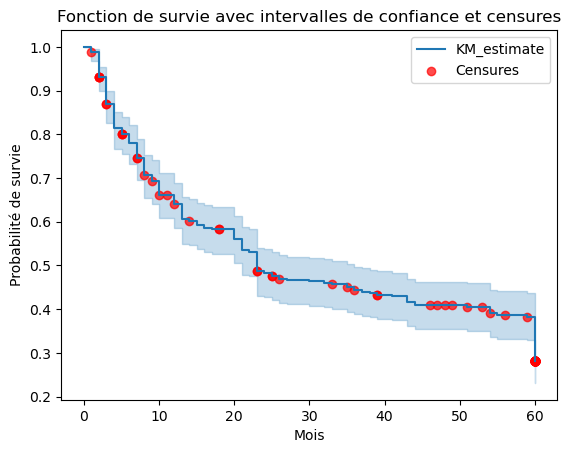

In [8]:
# Initialisation du Kaplan-Meier
kmf = KaplanMeierFitter()

# Ajustement du modèle avec les données
kmf.fit(df['Tempsdesuivi (Mois)'], event_observed=df['Deces'])

# Tracer la fonction de survie avec les intervalles de confiance
ax = kmf.plot_survival_function(ci_show=True)  # Affiche les intervalles de confiance

# Ajouter les points de censure
censored_times = df.loc[df['Deces'] == 0, 'Tempsdesuivi (Mois)']
survival_probabilities = [float(kmf.survival_function_at_times(time).iloc[0]) for time in censored_times]

plt.scatter(censored_times,
            survival_probabilities,
            color='red',
            label='Censures',
            alpha=0.7)

# Ajout des titres et légendes
plt.title('Fonction de survie avec intervalles de confiance et censures')
plt.xlabel('Mois')
plt.ylabel('Probabilité de survie')
plt.legend()
plt.show()



### **Probabilites de survie & de deces**

In [9]:
def probabilites_survie_deces(df, time_col, event_col):
    # Instancier l'estimateur Kaplan-Meier
    kmf = KaplanMeierFitter()

    # Ajuster le modèle à vos données
    kmf.fit(durations=df[time_col], event_observed=df[event_col])

    # Extraire les probabilités de survie
    survival_probabilities = kmf.survival_function_
    survival_probabilities.columns = ["Probabilité de survie"]

    # Calculer les probabilités de décès (1 - survie)
    survival_probabilities["Probabilité de décès"] = 1 - survival_probabilities["Probabilité de survie"]

    # Ajouter les temps (index)
    survival_probabilities.reset_index(inplace=True)
    survival_probabilities.rename(columns={"timeline": "Temps t"}, inplace=True)

    return survival_probabilities

# Exemple d'utilisation
# Charger vos données dans un DataFrame df
time_col = "Tempsdesuivi (Mois)"
event_col = "Deces"

# Appeler la fonction
resultat = probabilites_survie_deces(df, time_col, event_col)

# Afficher le tableau des probabilités
resultat

,Temps t,Probabilité de survie,Probabilité de décès
0,0.0,1.000000,0.000000
1,1.0,0.988131,0.011869
2,2.0,0.931581,0.068419
3,3.0,0.868270,0.131730
4,4.0,0.813623,0.186377
5,5.0,0.801480,0.198520
6,6.0,0.779984,0.220016
7,7.0,0.746205,0.253795
8,8.0,0.705953,0.294047
9,9.0,0.693514,0.306486


### **Taux de mortalites selon le sexe au file du temps**

In [10]:
def taux_mortalite_par_sexe(df, time_col, event_col, sexe_col):

    kmf = KaplanMeierFitter()
    resultats = {}

    # Diviser les données par sexe
    for sexe, group in df.groupby(sexe_col):
        # Ajuster le Kaplan-Meier pour chaque sexe
        kmf.fit(durations=group[time_col], event_observed=group[event_col], label=sexe)

        # Extraire les probabilités de décès cumulées
        surv_func = kmf.survival_function_.copy()
        surv_func["Probabilité de décès"] = 1 - surv_func.iloc[:, 0]  # 1 - Probabilité de survie
        surv_func.rename(columns={kmf._label: "Probabilité de survie"}, inplace=True)

        # Sauvegarder les résultats dans un dictionnaire
        surv_func.reset_index(inplace=True)
        surv_func.rename(columns={"timeline": "Temps t"}, inplace=True)
        resultats[sexe] = surv_func[["Temps t", "Probabilité de survie", "Probabilité de décès"]]

    return resultats

# Exemple d'utilisation
# Supposons un DataFrame `df` avec les colonnes "Tempsdesuivi (Mois)", "Deces" et "SEXE"
time_col = "Tempsdesuivi (Mois)"
event_col = "Deces"
sexe_col = "SEXE"  # Par exemple, 0 = Femme, 1 = Homme

# Appeler la fonction
taux_par_sexe = taux_mortalite_par_sexe(df, time_col, event_col, sexe_col)

# Afficher les résultats pour chaque groupe
for sexe, tableau in taux_par_sexe.items():
    print(f"\nTaux de mortalité pour le sexe : {sexe}")
    print(tableau)



Taux de mortalité pour le sexe : 0
    Temps t  Probabilité de survie  Probabilité de décès
0       0.0               1.000000              0.000000
1       1.0               0.980769              0.019231
2       2.0               0.942308              0.057692
3       3.0               0.896817              0.103183
4       4.0               0.811718              0.188282
5       5.0               0.798625              0.201375
6       6.0               0.785315              0.214685
7       7.0               0.745384              0.254616
8       8.0               0.705452              0.294548
9       9.0               0.692015              0.307985
10     10.0               0.651308              0.348692
11     12.0               0.617386              0.382614
12     13.0               0.583087              0.416913
13     14.0               0.583087              0.416913
14     16.0               0.576145              0.423855
15     18.0               0.576145              0.42

## **Tracer des courbes de Kaplan-Meier pour chaque groupe de la variable**

#### **Menu Déroulant**

In [11]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from IPython.display import display

# Initialisation des variables
time_col = "Tempsdesuivi (Mois)"
event_col = "Deces"
vars = [
    'Cardiopathie', 'Ulceregastrique', 'Douleurepigastrique',
    'Ulcero-bourgeonnant', 'Constipation', 'Denitrution', 'Tabac',
    'Mucineux', 'Tubuleux', 'Infiltrant', 'Stenosant', 'Metastases',
    'Adenopathie', 'Traitement', "SEXE"
]

# Définir des labels descriptifs pour les groupes
labels = {
    'Traitement': {0: "Chirurgie_Chimiothérapie", 1: "Chirurgie_Exclusive"},
    'SEXE': {0: "Femme", 1: "Homme"},
}

# Appliquer des labels génériques "Non" / "Oui" pour les autres variables
for var in vars:
    if var not in labels:
        labels[var] = {0: "Non", 1: "Oui"}

# Fonction de création du graphique Kaplan-Meier
def plot_kaplan_meier(variable):
    """
    Trace le graphique Kaplan-Meier pour une variable donnée et effectue le test de log-rank.
    """
    # Initialisation de la figure
    fig, ax = plt.subplots(figsize=(8, 4))

    # Instanciation du KaplanMeierFitter
    kmf = KaplanMeierFitter()

    # Tracer les courbes Kaplan-Meier pour chaque groupe de la variable
    for group in df[variable].unique():
        mask = (df[variable] == group)
        label = labels.get(variable, {}).get(group, str(group))  # Utiliser des labels ou des valeurs par défaut
        kmf.fit(df.loc[mask, time_col], event_observed=df.loc[mask, event_col], label=label)
        kmf.plot(ax=ax)

    # Test de log-rank entre les groupes
    groups = df[variable].unique()
    if len(groups) == 2:  # Test seulement si deux groupes existent
        group_0 = df.loc[df[variable] == groups[0]]
        group_1 = df.loc[df[variable] == groups[1]]
        results = logrank_test(
            group_0[time_col],
            group_1[time_col],
            event_observed_A=group_0[event_col],
            event_observed_B=group_1[event_col]
        )
        p_value = results.p_value
        ax.set_title(f"{variable}\nLog-rank p = {p_value:.4f}", fontsize=12)
    else:
        ax.set_title(f"{variable} (Pas de test log-rank, plus de 2 groupes)", fontsize=12)

    # Configurations supplémentaires
    ax.set_xlabel("Temps (mois)", fontsize=10)
    ax.set_ylabel("Probabilité de survie", fontsize=10)
    ax.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

# Menu déroulant pour sélectionner la variable à analyser
dropdown = widgets.Dropdown(
    options=vars,
    value='Traitement',  # Valeur par défaut
    description='Variable:',
    disabled=False
)

# Afficher le menu et le graphique interactif
widgets.interactive(plot_kaplan_meier, variable=dropdown)


interactive(children=(Dropdown(description='Variable:', index=13, options=('Cardiopathie', 'Ulceregastrique', …

### **Variables significatives**

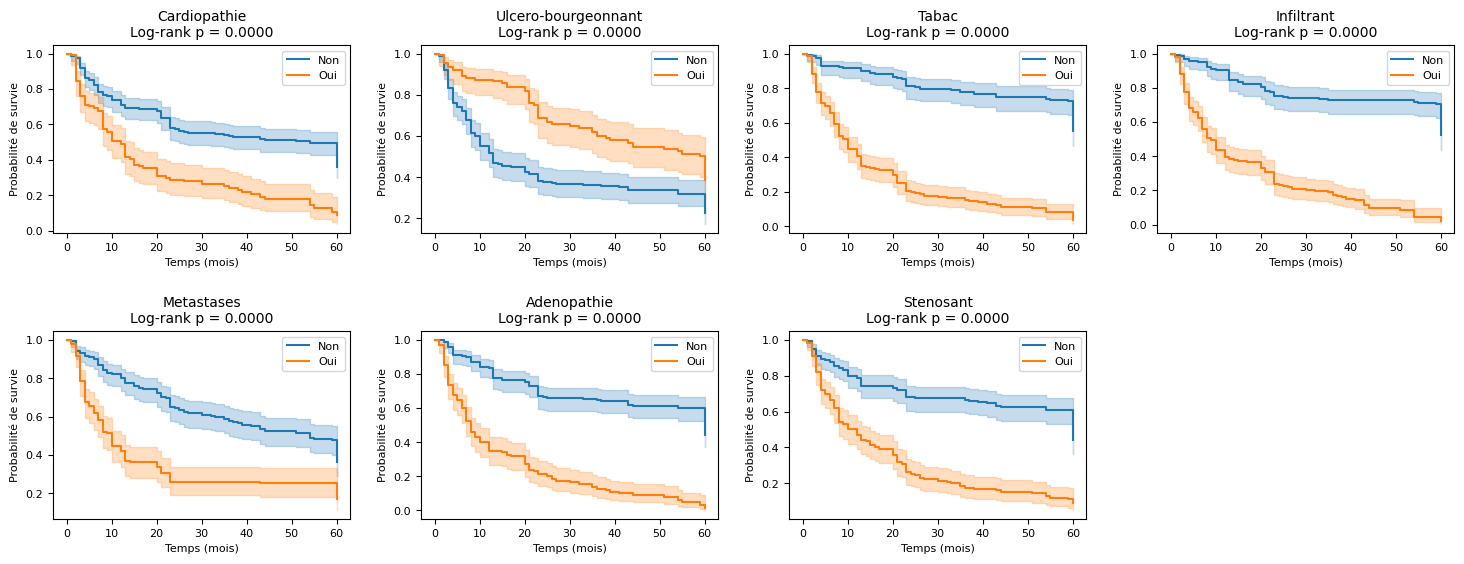

In [12]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Initialisation des variables
time_col = "Tempsdesuivi (Mois)"  # Nom de la colonne temps
event_col = "Deces"  # Nom de la colonne événement
vars = [
    'Cardiopathie',
    'Ulcero-bourgeonnant', 'Tabac',
     'Infiltrant', 'Metastases',
    'Adenopathie','Stenosant'
]

# Définir des labels descriptifs pour les groupes
labels = {
    'Traitement': {0: "Chirurgie_Chimiothérapie", 1: "Chirurgie_Exclusive"},
    'SEXE': {0: "Femme", 1: "Homme"},
    **{var: {0: "Non", 1: "Oui"} for var in vars if var not in ['Traitement', 'SEXE']}
}

# Déterminer la disposition de la grille pour les sous-graphiques
n_vars = len(vars)
n_cols = 4  # Augmenter le nombre de colonnes pour une disposition compacte
n_rows = (n_vars + n_cols - 1) // n_cols  # Calcul du nombre de lignes

# Création d'une figure compacte avec une grille
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
axes = axes.flatten()  # Convertir les axes en une liste pour un accès facile

for idx, var in enumerate(vars):
    ax = axes[idx]

    # Instanciation du KaplanMeierFitter
    kmf = KaplanMeierFitter()

    # Tracer les courbes de Kaplan-Meier pour chaque groupe de la variable
    for group in [0, 1]:
        mask = (df[var] == group)
        label = labels[var][group]  # Utiliser les labels descriptifs
        kmf.fit(df.loc[mask, time_col], event_observed=df.loc[mask, event_col], label=label)
        kmf.plot(ax=ax)

    # Test de log-rank entre les groupes 0 et 1
    results = logrank_test(
        df.loc[df[var] == 0, time_col],
        df.loc[df[var] == 1, time_col],
        event_observed_A=df.loc[df[var] == 0, event_col],
        event_observed_B=df.loc[df[var] == 1, event_col]
    )
    p_value = results.p_value

    # Ajouter le titre et le résultat du test de log-rank
    ax.set_title(f"{var}\nLog-rank p = {p_value:.4f}", fontsize=10)
    ax.set_xlabel("Temps (mois)", fontsize=8)
    ax.set_ylabel("Probabilité de survie", fontsize=8)
    ax.legend(fontsize=8)
    ax.tick_params(axis="both", labelsize=8)

# Supprimer les axes inutilisés si le nombre de variables n'est pas un multiple du nombre de colonnes
for idx in range(len(vars), len(axes)):
    fig.delaxes(axes[idx])

# Ajuster les espacements pour une disposition compacte
plt.tight_layout(pad=2.0)
plt.show()

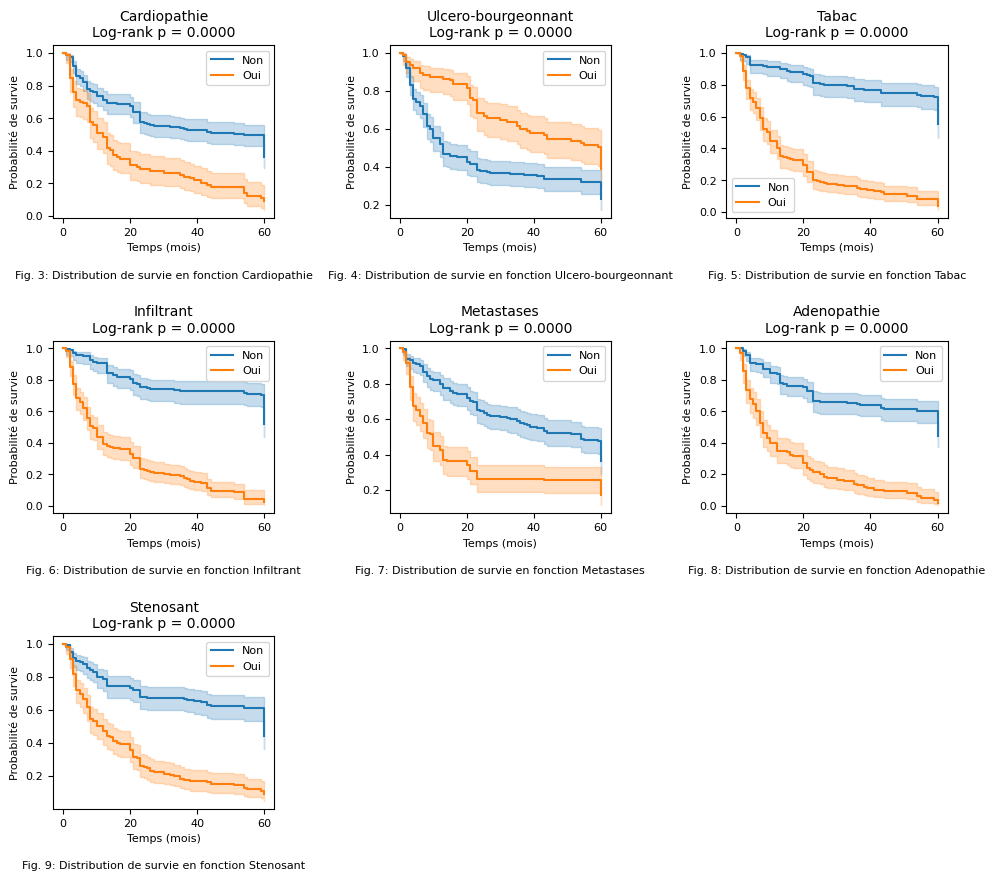

In [13]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Initialisation des variables
time_col = "Tempsdesuivi (Mois)"  # Nom de la colonne temps
event_col = "Deces"  # Nom de la colonne événement
vars = [
    'Cardiopathie',
    'Ulcero-bourgeonnant', 'Tabac',
    'Infiltrant', 'Metastases',
    'Adenopathie', 'Stenosant'
]

# Définir des labels descriptifs pour les groupes
labels = {
    'Traitement': {0: "Chirurgie_Chimiothérapie", 1: "Chirurgie_Exclusive"},
    'SEXE': {0: "Femme", 1: "Homme"},
    **{var: {0: "Non", 1: "Oui"} for var in vars if var not in ['Traitement', 'SEXE']}
}

# Déterminer la disposition de la grille pour les sous-graphiques
n_vars = len(vars)
n_cols = 3  # Augmenter le nombre de colonnes pour une disposition compacte
n_rows = (n_vars + n_cols - 1) // n_cols  # Calcul du nombre de lignes

# Création d'une figure compacte avec une grille
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))
axes = axes.flatten()  # Convertir les axes en une liste pour un accès facile

for idx, var in enumerate(vars):
    ax = axes[idx]

    # Instanciation du KaplanMeierFitter
    kmf = KaplanMeierFitter()

    # Tracer les courbes de Kaplan-Meier pour chaque groupe de la variable
    for group in [0, 1]:
        mask = (df[var] == group)
        label = labels[var][group]  # Utiliser les labels descriptifs
        kmf.fit(df.loc[mask, time_col], event_observed=df.loc[mask, event_col], label=label)
        kmf.plot(ax=ax)

    # Test de log-rank entre les groupes 0 et 1
    results = logrank_test(
        df.loc[df[var] == 0, time_col],
        df.loc[df[var] == 1, time_col],
        event_observed_A=df.loc[df[var] == 0, event_col],
        event_observed_B=df.loc[df[var] == 1, event_col]
    )
    p_value = results.p_value

    # Ajouter le titre et le résultat du test de log-rank
    ax.set_title(f"{var}\nLog-rank p = {p_value:.4f}", fontsize=10)
    ax.set_xlabel("Temps (mois)", fontsize=8)
    ax.set_ylabel("Probabilité de survie", fontsize=8)
    ax.legend(fontsize=8)
    ax.tick_params(axis="both", labelsize=8)

    # Ajouter le numéro de la figure sous chaque graphe
    ax.text(0.5, -0.35, f"Fig. {idx + 3}: Distribution de survie en fonction {var}",
            transform=ax.transAxes, ha="center", fontsize=8)


# Supprimer les axes inutilisés si le nombre de variables n'est pas un multiple du nombre de colonnes
for idx in range(len(vars), len(axes)):
    fig.delaxes(axes[idx])

# Ajuster les espacements pour une disposition compacte
plt.tight_layout(pad=1.0)
plt.show()


### **Resultats du test de log-Rank**

In [14]:
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Colonnes importantes
time_col = "Tempsdesuivi (Mois)"  # Durée de suivi
event_col = "Deces"  # Événement : 1 = décès, 0 = censuré

# Liste des variables à analyser
factors = [
    'SEXE', 'Cardiopathie', 'Ulceregastrique', 'Douleurepigastrique',
    'Ulcero-bourgeonnant', 'Constipation', 'Denitrution', 'Tabac',
    'Mucineux', 'Tubuleux', 'Infiltrant', 'Stenosant', 'Metastases',
    'Adenopathie', 'Traitement'
]

# Résultats finaux
results = []

# Fonction pour calculer la moyenne de survie
def calculate_mean_survival_time(kmf):
    durations = kmf.event_table.index.values
    survival_probabilities = kmf.survival_function_.values.flatten()
    time_differences = durations[1:] - durations[:-1]
    mean_survival_time = sum(time_differences * survival_probabilities[:-1])
    return mean_survival_time

# Estimation Kaplan-Meier et Log-rank pour chaque variable
for factor in factors:
    print(f"Analyse pour la variable : {factor}")
    unique_values = df[factor].dropna().unique()

    if len(unique_values) > 1:  # Vérifier que la variable a au moins 2 modalités
        kmf = KaplanMeierFitter()
        group_survival = {}

        # Appliquer Kaplan-Meier pour chaque groupe
        for value in unique_values:
            group = df[df[factor] == value]
            kmf.fit(group[time_col], event_observed=group[event_col])

            # Calculer la moyenne et stocker les résultats
            mean_survival_time = calculate_mean_survival_time(kmf)
            median_survival_time = kmf.median_survival_time_

            group_survival[value] = {
                "mean_survival_time": mean_survival_time,
                "median_survival_time": median_survival_time
            }

            print(f"  Groupe {value}: Moyenne = {mean_survival_time:.2f}, Médiane = {median_survival_time:.2f}")

        # Comparer les groupes avec un test de Log-rank
        group_1 = df[df[factor] == unique_values[0]]
        group_2 = df[df[factor] == unique_values[1]]

        logrank = logrank_test(
            group_1[time_col], group_2[time_col],
            event_observed_A=group_1[event_col], event_observed_B=group_2[event_col]
        )

        # Stocker les résultats
        results.append({
            "variable": factor,
            "group_1": unique_values[0],
            "group_2": unique_values[1],
            "p_value": logrank.p_value,
            "test_statistic": logrank.test_statistic,
            "group_1_mean": group_survival[unique_values[0]]["mean_survival_time"],
            "group_1_median": group_survival[unique_values[0]]["median_survival_time"],
            "group_2_mean": group_survival[unique_values[1]]["mean_survival_time"],
            "group_2_median": group_survival[unique_values[1]]["median_survival_time"],
        })
    else:
        print(f"  La variable {factor} n'a qu'une seule modalité. Analyse non réalisée.\n")

Analyse pour la variable : SEXE
  Groupe 0: Moyenne = 31.44, Médiane = 21.00
  Groupe 1: Moyenne = 32.44, Médiane = 25.00
Analyse pour la variable : Cardiopathie
  Groupe 0: Moyenne = 37.20, Médiane = 54.00
  Groupe 1: Moyenne = 20.41, Médiane = 12.00
Analyse pour la variable : Ulceregastrique
  Groupe 0: Moyenne = 35.92, Médiane = 60.00
  Groupe 1: Moyenne = 25.78, Médiane = 21.00
Analyse pour la variable : Douleurepigastrique
  Groupe 1: Moyenne = 33.03, Médiane = 24.00
  Groupe 0: Moyenne = 25.11, Médiane = 4.00
Analyse pour la variable : Ulcero-bourgeonnant
  Groupe 0: Moyenne = 26.87, Médiane = 13.00
  Groupe 1: Moyenne = 41.82, Médiane = 60.00
Analyse pour la variable : Constipation
  Groupe 1: Moyenne = 28.49, Médiane = 21.00
  Groupe 0: Moyenne = 35.87, Médiane = 60.00
Analyse pour la variable : Denitrution
  Groupe 1: Moyenne = 27.46, Médiane = 17.00
  Groupe 0: Moyenne = 34.35, Médiane = 25.00
Analyse pour la variable : Tabac
  Groupe 1: Moyenne = 16.76, Médiane = 10.00
  Gro

In [15]:
# Résumer les résultats dans un DataFrame
results_df = pd.DataFrame(results)
# Afficher les résultats
print("\nRésumé des résultats :")
results_df


Résumé des résultats :


,variable,group_1,group_2,p_value,test_statistic,group_1_mean,group_1_median,group_2_mean,group_2_median
0,SEXE,0,1,7.406859e-01,0.109525,31.437693,21.0,32.436142,25.0
1,Cardiopathie,0,1,7.829494e-11,42.299941,37.198237,54.0,20.405536,12.0
2,Ulceregastrique,0,1,9.106486e-07,24.108344,35.923690,60.0,25.781490,21.0
3,Douleurepigastrique,1,0,1.505095e-01,2.067079,33.033679,24.0,25.113024,4.0
4,Ulcero-bourgeonnant,0,1,1.127879e-05,19.281603,26.873642,13.0,41.823903,60.0
5,Constipation,1,0,1.342754e-02,6.111891,28.489588,21.0,35.867868,60.0
6,Denitrution,1,0,2.821128e-03,8.919687,27.459038,17.0,34.352213,25.0
7,Tabac,1,0,3.911887e-38,166.688892,16.755475,10.0,49.402280,inf
8,Mucineux,1,0,7.713190e-01,0.084477,31.266892,21.0,33.217223,26.0
9,Tubuleux,0,1,1.301695e-11,45.811914,18.623619,10.0,37.335463,59.0


### **Test de Lo-Rank : Variables significtives**

In [16]:
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Colonnes importantes
time_col = "Tempsdesuivi (Mois)"  # Durée de suivi
event_col = "Deces"  # Événement : 1 = décès, 0 = censuré

# Liste des variables à analyser
factors = [
    'Cardiopathie', 'Ulcero-bourgeonnant', 'Tabac', 'Infiltrant',
    'Metastases', 'Adenopathie','Stenosant'
]

# Résultats finaux
results = []

# Fonction pour calculer la moyenne de survie
def calculate_mean_survival_time(kmf):
    durations = kmf.event_table.index.values
    survival_probabilities = kmf.survival_function_.values.flatten()
    time_differences = durations[1:] - durations[:-1]
    mean_survival_time = sum(time_differences * survival_probabilities[:-1])
    return mean_survival_time

# Estimation Kaplan-Meier et Log-rank pour chaque variable
for factor in factors:
    #print(f"Analyse pour la variable : {factor}")
    unique_values = df[factor].dropna().unique()

    if len(unique_values) > 1:  # Vérifier que la variable a au moins 2 modalités
        kmf = KaplanMeierFitter()
        group_survival = {}

        # Appliquer Kaplan-Meier pour chaque groupe
        for value in unique_values:
            group = df[df[factor] == value]
            kmf.fit(group[time_col], event_observed=group[event_col])

            # Calculer la moyenne et stocker les résultats
            mean_survival_time = calculate_mean_survival_time(kmf)
            median_survival_time = kmf.median_survival_time_

            group_survival[value] = {
                "mean_survival_time": mean_survival_time,
                "median_survival_time": median_survival_time
            }

            #print(f"  Groupe {value}: Moyenne = {mean_survival_time:.2f}, Médiane = {median_survival_time:.2f}")

        # Comparer les groupes avec un test de Log-rank
        group_1 = df[df[factor] == unique_values[0]]
        group_2 = df[df[factor] == unique_values[1]]

        logrank = logrank_test(
            group_1[time_col], group_2[time_col],
            event_observed_A=group_1[event_col], event_observed_B=group_2[event_col]
        )

        # Stocker les résultats
        results.append({
            "variable": factor,
            "group_1": unique_values[0],
            "group_2": unique_values[1],
            "p_value": logrank.p_value,
            "test_statistic": logrank.test_statistic,
            "group_1_mean": group_survival[unique_values[0]]["mean_survival_time"],
            "group_1_median": group_survival[unique_values[0]]["median_survival_time"],
            "group_2_mean": group_survival[unique_values[1]]["mean_survival_time"],
            "group_2_median": group_survival[unique_values[1]]["median_survival_time"],
        })
    else:
        print(f"  La variable {factor} n'a qu'une seule modalité. Analyse non réalisée.\n")

# Résumer les résultats dans un DataFrame
results_df = pd.DataFrame(results)
# Afficher les résultats
print("\nRésumé des résultats :")
results_df


Résumé des résultats :


,variable,group_1,group_2,p_value,test_statistic,group_1_mean,group_1_median,group_2_mean,group_2_median
0,Cardiopathie,0,1,7.829494e-11,42.299941,37.198237,54.0,20.405536,12.0
1,Ulcero-bourgeonnant,0,1,1.127879e-05,19.281603,26.873642,13.0,41.823903,60.0
2,Tabac,1,0,3.911887e-38,166.688892,16.755475,10.0,49.402280,inf
3,Infiltrant,1,0,2.607868e-35,153.764087,17.076847,9.0,47.450964,inf
4,Metastases,1,0,1.001639e-09,37.321698,21.574052,10.0,39.569722,54.0
5,Adenopathie,1,0,6.833138e-32,138.127889,15.441106,8.0,42.781509,60.0
6,Stenosant,1,0,3.374703e-19,80.205244,19.285141,12.0,42.668364,60.0


### **Variables non significatives**

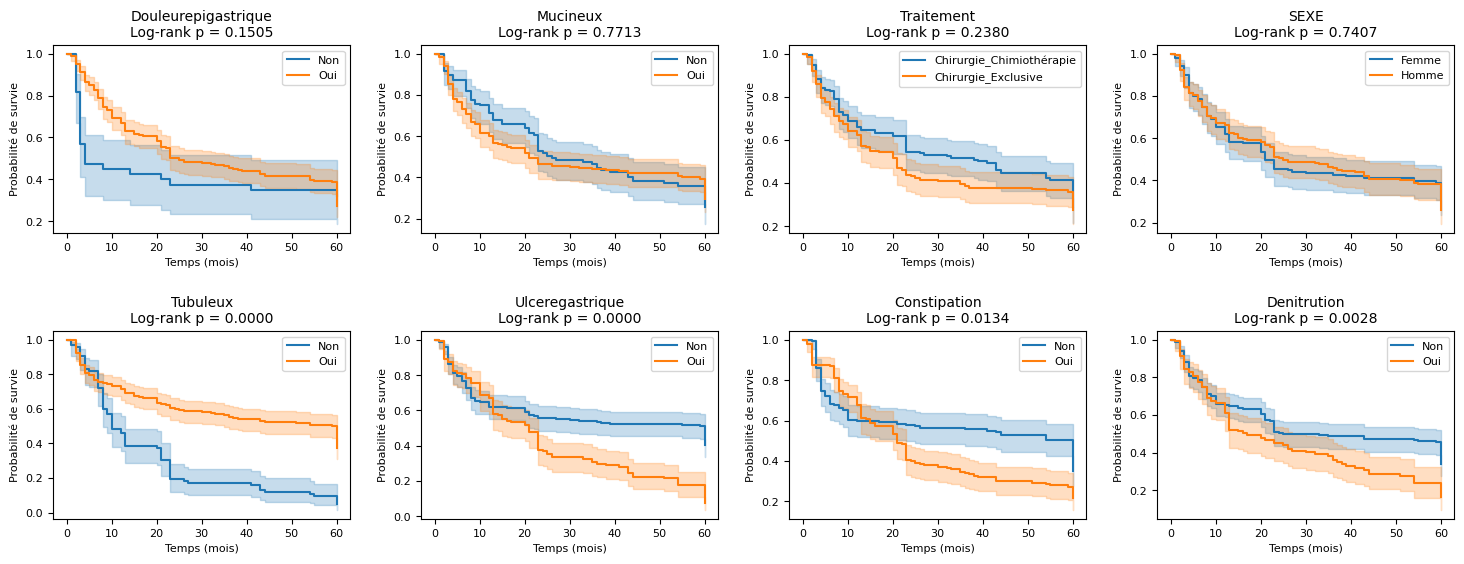

In [17]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Initialisation des variables
time_col = "Tempsdesuivi (Mois)"  # Nom de la colonne temps
event_col = "Deces"  # Nom de la colonne événement
vars = [
    'Douleurepigastrique','Mucineux', 'Traitement', "SEXE",'Tubuleux',
    'Ulceregastrique','Constipation', 'Denitrution'
]

# Définir des labels descriptifs pour les groupes
labels = {
    'Traitement': {0: "Chirurgie_Chimiothérapie", 1: "Chirurgie_Exclusive"},
    'SEXE': {0: "Femme", 1: "Homme"},
    **{var: {0: "Non", 1: "Oui"} for var in vars if var not in ['Traitement', 'SEXE']}
}

# Déterminer la disposition de la grille pour les sous-graphiques
n_vars = len(vars)
n_cols = 4 # Augmenter le nombre de colonnes pour une disposition compacte
n_rows = (n_vars + n_cols - 1) // n_cols  # Calcul du nombre de lignes

# Création d'une figure compacte avec une grille
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3* n_rows))
axes = axes.flatten()  # Convertir les axes en une liste pour un accès facile

for idx, var in enumerate(vars):
    ax = axes[idx]

    # Instanciation du KaplanMeierFitter
    kmf = KaplanMeierFitter()

    # Tracer les courbes de Kaplan-Meier pour chaque groupe de la variable
    for group in [0, 1]:
        mask = (df[var] == group)
        label = labels[var][group]  # Utiliser les labels descriptifs
        kmf.fit(df.loc[mask, time_col], event_observed=df.loc[mask, event_col], label=label)
        kmf.plot(ax=ax)

    # Test de log-rank entre les groupes 0 et 1
    results = logrank_test(
        df.loc[df[var] == 0, time_col],
        df.loc[df[var] == 1, time_col],
        event_observed_A=df.loc[df[var] == 0, event_col],
        event_observed_B=df.loc[df[var] == 1, event_col]
    )
    p_value = results.p_value

    # Ajouter le titre et le résultat du test de log-rank
    ax.set_title(f"{var}\nLog-rank p = {p_value:.4f}", fontsize=10)
    ax.set_xlabel("Temps (mois)", fontsize=8)
    ax.set_ylabel("Probabilité de survie", fontsize=8)
    ax.legend(fontsize=8)
    ax.tick_params(axis="both", labelsize=8)

# Supprimer les axes inutilisés si le nombre de variables n'est pas un multiple du nombre de colonnes
for idx in range(len(vars), len(axes)):
    fig.delaxes(axes[idx])

# Ajuster les espacements pour une disposition compacte
plt.tight_layout(pad=2.0)
plt.show()

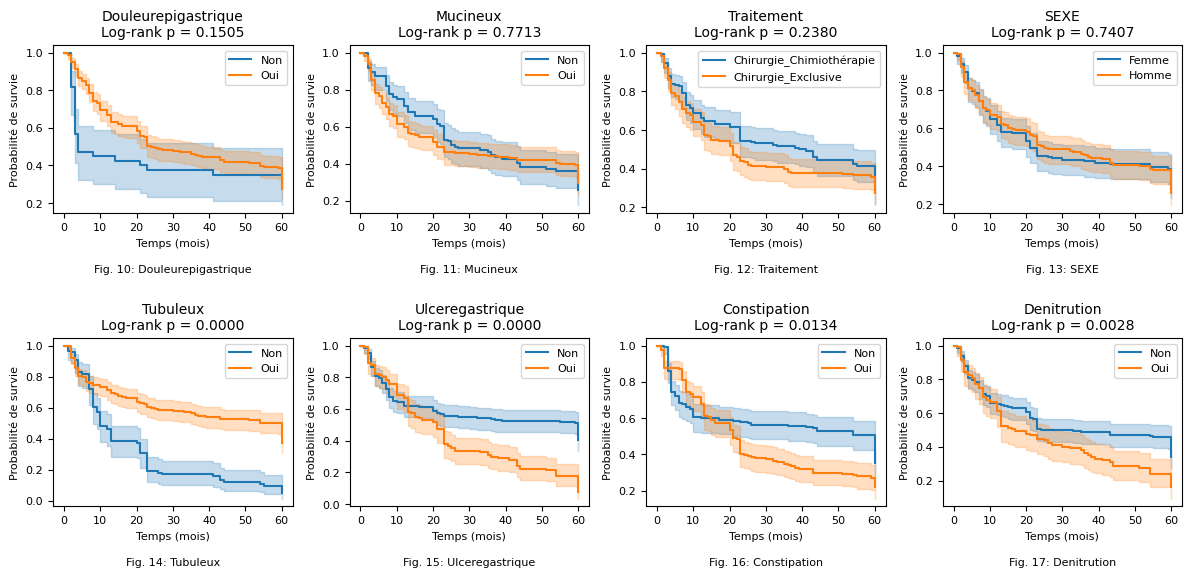

In [18]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Initialisation des variables
time_col = "Tempsdesuivi (Mois)"  # Nom de la colonne temps
event_col = "Deces"  # Nom de la colonne événement
vars = [
    'Douleurepigastrique','Mucineux', 'Traitement', "SEXE",'Tubuleux',
    'Ulceregastrique','Constipation', 'Denitrution'
]

# Définir des labels descriptifs pour les groupes
labels = {
    'Traitement': {0: "Chirurgie_Chimiothérapie", 1: "Chirurgie_Exclusive"},
    'SEXE': {0: "Femme", 1: "Homme"},
    **{var: {0: "Non", 1: "Oui"} for var in vars if var not in ['Traitement', 'SEXE']}
}

# Déterminer la disposition de la grille pour les sous-graphiques
n_vars = len(vars)
n_cols = 4  # Augmenter le nombre de colonnes pour une disposition compacte
n_rows = (n_vars + n_cols - 1) // n_cols  # Calcul du nombre de lignes

# Création d'une figure compacte avec une grille
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
axes = axes.flatten()  # Convertir les axes en une liste pour un accès facile

for idx, var in enumerate(vars):
    ax = axes[idx]

    # Instanciation du KaplanMeierFitter
    kmf = KaplanMeierFitter()

    # Tracer les courbes de Kaplan-Meier pour chaque groupe de la variable
    for group in [0, 1]:
        mask = (df[var] == group)
        label = labels[var][group]  # Utiliser les labels descriptifs
        kmf.fit(df.loc[mask, time_col], event_observed=df.loc[mask, event_col], label=label)
        kmf.plot(ax=ax)

    # Test de log-rank entre les groupes 0 et 1
    results = logrank_test(
        df.loc[df[var] == 0, time_col],
        df.loc[df[var] == 1, time_col],
        event_observed_A=df.loc[df[var] == 0, event_col],
        event_observed_B=df.loc[df[var] == 1, event_col]
    )
    p_value = results.p_value

    # Ajouter le titre et le résultat du test de log-rank
    ax.set_title(f"{var}\nLog-rank p = {p_value:.4f}", fontsize=10)
    ax.set_xlabel("Temps (mois)", fontsize=8)
    ax.set_ylabel("Probabilité de survie", fontsize=8)
    ax.legend(fontsize=8)
    ax.tick_params(axis="both", labelsize=8)

    # Ajouter le numéro de la figure sous chaque graphe
    ax.text(0.5, -0.35, f"Fig. {idx + 10}: {var}",
            transform=ax.transAxes, ha="center", fontsize=8)


# Supprimer les axes inutilisés si le nombre de variables n'est pas un multiple du nombre de colonnes
for idx in range(len(vars), len(axes)):
    fig.delaxes(axes[idx])

# Ajuster les espacements pour une disposition compacte
plt.tight_layout(pad=1.0)
plt.show()


### **Test de Log-Rank : Variables Non Significatives**

In [19]:
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Colonnes importantes
time_col = "Tempsdesuivi (Mois)"  # Durée de suivi
event_col = "Deces"  # Événement : 1 = décès, 0 = censuré

# Liste des variables à analyser
factors = [
    'Douleurepigastrique','Mucineux', 'Traitement', "SEXE",'Tubuleux',
    'Ulceregastrique','Constipation', 'Denitrution'
]

# Résultats finaux
results = []

# Fonction pour calculer la moyenne de survie
def calculate_mean_survival_time(kmf):
    durations = kmf.event_table.index.values
    survival_probabilities = kmf.survival_function_.values.flatten()
    time_differences = durations[1:] - durations[:-1]
    mean_survival_time = sum(time_differences * survival_probabilities[:-1])
    return mean_survival_time

# Estimation Kaplan-Meier et Log-rank pour chaque variable
for factor in factors:
    #print(f"Analyse pour la variable : {factor}")
    unique_values = df[factor].dropna().unique()

    if len(unique_values) > 1:  # Vérifier que la variable a au moins 2 modalités
        kmf = KaplanMeierFitter()
        group_survival = {}

        # Appliquer Kaplan-Meier pour chaque groupe
        for value in unique_values:
            group = df[df[factor] == value]
            kmf.fit(group[time_col], event_observed=group[event_col])

            # Calculer la moyenne et stocker les résultats
            mean_survival_time = calculate_mean_survival_time(kmf)
            median_survival_time = kmf.median_survival_time_

            group_survival[value] = {
                "mean_survival_time": mean_survival_time,
                "median_survival_time": median_survival_time
            }

            #print(f"  Groupe {value}: Moyenne = {mean_survival_time:.2f}, Médiane = {median_survival_time:.2f}")

        # Comparer les groupes avec un test de Log-rank
        group_1 = df[df[factor] == unique_values[0]]
        group_2 = df[df[factor] == unique_values[1]]

        logrank = logrank_test(
            group_1[time_col], group_2[time_col],
            event_observed_A=group_1[event_col], event_observed_B=group_2[event_col]
        )

        # Stocker les résultats
        results.append({
            "variable": factor,
            "group_1": unique_values[0],
            "group_2": unique_values[1],
            "p_value": logrank.p_value,
            "test_statistic": logrank.test_statistic,
            "group_1_mean": group_survival[unique_values[0]]["mean_survival_time"],
            "group_1_median": group_survival[unique_values[0]]["median_survival_time"],
            "group_2_mean": group_survival[unique_values[1]]["mean_survival_time"],
            "group_2_median": group_survival[unique_values[1]]["median_survival_time"],
        })
    else:
        print(f"  La variable {factor} n'a qu'une seule modalité. Analyse non réalisée.\n")

# Résumer les résultats dans un DataFrame
results_df = pd.DataFrame(results)
# Afficher les résultats
print("\nRésumé des résultats :")
results_df


Résumé des résultats :


,variable,group_1,group_2,p_value,test_statistic,group_1_mean,group_1_median,group_2_mean,group_2_median
0,Douleurepigastrique,1,0,1.505095e-01,2.067079,33.033679,24.0,25.113024,4.0
1,Mucineux,1,0,7.713190e-01,0.084477,31.266892,21.0,33.217223,26.0
2,Traitement,1,0,2.380196e-01,1.392285,29.743202,21.0,34.739229,41.0
3,SEXE,0,1,7.406859e-01,0.109525,31.437693,21.0,32.436142,25.0
4,Tubuleux,0,1,1.301695e-11,45.811914,18.623619,10.0,37.335463,59.0
5,Ulceregastrique,0,1,9.106486e-07,24.108344,35.923690,60.0,25.781490,21.0
6,Constipation,1,0,1.342754e-02,6.111891,28.489588,21.0,35.867868,60.0
7,Denitrution,1,0,2.821128e-03,8.919687,27.459038,17.0,34.352213,25.0


# **II. Modele a risque proportionnel de Cox**
La méthode de Kaplan-Meier ne tient pas compte des variables confondantes. Ont peut utilisé le modèle de Cox Proportional Hazards pour ajuster les résultats en fonction de variables.

In [20]:
from lifelines import CoxPHFitter
# Ajuster le modèle de Cox
cph = CoxPHFitter()
cph.fit(df, duration_col="Tempsdesuivi (Mois)", event_col="Deces")
cph.print_summary()
# Visualiser les coefficients de survie
cph.plot()

<lifelines.CoxPHFitter: fitted with 337 total observations, 114 right-censored observations>
             duration col = 'Tempsdesuivi (Mois)'
                event col = 'Deces'
      baseline estimation = breslow
   number of observations = 337
number of events observed = 223
   partial log-likelihood = -996.10
         time fit was run = 2025-02-23 18:32:48 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
AGE                 -0.02      0.98      0.01           -0.04           -0.01                0.96                0.99
SEXE                -0.17      0.84      0.15           -0.47            0.13                0.62                1.13
Cardiopathie         0.49      1.64      0.16            0.18            0.81                1.19                2.25
Ulceregastrique      0.49      1.63      0.16            0.18            0.81                1.19                2.24
Douleurepigastrique -0.71      0.49      0.23           -1.17           -0.25                0.31                0.78
Ulcero-bourgeonnant -0.47      0.62      0.17           -0.81           -0.13                0.44                0.87
Constipation        -0.01      0.99      0.15           -0.30            0.28                0.74                1.32
Denitrution         -0.59      0.55      0.17           -0.92           -0.26                0.40                0.77
Tabac                1.18      3.25      0.22            0.74            1.62                2.10                5.03
Mucineux            -0.71      0.49      0.20           -1.10           -0.33                0.33                0.72
Tubuleux            -0.27      0.76      0.16           -0.58            0.04                0.56                1.04
Infiltrant           1.05      2.86      0.20            0.65            1.45                1.92                4.27
Stenosant            0.49      1.63      0.17            0.16            0.82                1.17                2.26
Metastases           1.23      3.42      0.21            0.82            1.64                2.28                5.14
Adenopathie          0.99      2.68      0.20            0.60            1.38                1.82                3.96
Traitement           0.05      1.06      0.14           -0.22            0.33                0.80                1.39

                     cmp to     z      p  -log2(p)
covariate                                         
AGE                    0.00 -3.04 <0.005      8.72
SEXE                   0.00 -1.14   0.25      1.98
Cardiopathie           0.00  3.06 <0.005      8.83
Ulceregastrique        0.00  3.05 <0.005      8.78
Douleurepigastrique    0.00 -3.04 <0.005      8.73
Ulcero-bourgeonnant    0.00 -2.74   0.01      7.36
Constipation           0.00 -0.07   0.94      0.09
Denitrution            0.00 -3.52 <0.005     11.20
Tabac                  0.00  5.31 <0.005     23.10
Mucineux               0.00 -3.62 <0.005     11.71
Tubuleux               0.00 -1.71   0.09      3.52
Infiltrant             0.00  5.14 <0.005     21.83
Stenosant              0.00  2.91 <0.005      8.11
Metastases             0.00  5.93 <0.005     28.32
Adenopathie            0.00  4.98 <0.005     20.55
Traitement             0.00  0.39   0.70      0.51
---
Concordance = 0.85
Partial AIC = 2024.20
log-likelihood ratio test = 356.27 on 16 df
-log2(p) of ll-ratio test = 216.90

<Axes: xlabel='log(HR) (95% CI)'>

 ## **Implémentation de la sélection pas à pas (stepwise selection)**

In [21]:
from lifelines import CoxPHFitter
from lifelines.exceptions import ConvergenceWarning
import pandas as pd
from typing import List, Optional
import warnings

def stepwise_selection(
    df: pd.DataFrame,
    time_col: str,
    event_col: str,
    variables: List[str],
    threshold_in: float = 0.05,
    threshold_out: float = 0.10,
    max_steps: Optional[int] = 20,
    verbose: bool = True,
    **cox_params
) -> List[str]:
    """
    Effectue une sélection pas à pas (forward-backward) pour un modèle de régression de Cox.

    Parameters:
        df (pd.DataFrame): DataFrame contenant les données
        time_col (str): Colonne du temps de suivi
        event_col (str): Colonne de l'événement d'intérêt (1: événement, 0: censure)
        variables (List[str]): Variables candidates pour la sélection
        threshold_in (float): Seuil de p-value pour inclusion (forward)
        threshold_out (float): Seuil de p-value pour exclusion (backward)
        max_steps (Optional[int]): Nombre maximal d'itérations
        verbose (bool): Affichage des messages de progression
        **cox_params: Paramètres supplémentaires pour CoxPHFitter

    Returns:
        List[str]: Liste des variables sélectionnées
    """

    # Validation des entrées
    if not isinstance(df, pd.DataFrame):
        raise ValueError("L'argument df doit être un DataFrame pandas")
    
    required_columns = [time_col, event_col] + variables
    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Colonnes manquantes: {missing_cols}")
    
    if not (0 < threshold_in < 1) or not (0 < threshold_out < 1):
        raise ValueError("Les seuils doivent être entre 0 et 1")

    selected_vars = []
    remaining_vars = list(variables)
    steps = 0

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning)
        
        while remaining_vars and steps < max_steps:
            changed = False
            steps += 1

            # Phase forward
            best_var = None
            best_p = float('inf')
            
            for var in remaining_vars:
                try:
                    model_vars = selected_vars + [var]
                    cph = CoxPHFitter(**cox_params)
                    cph.fit(
                        df[[time_col, event_col] + model_vars],
                        duration_col=time_col,
                        event_col=event_col,
                        show_progress=False
                    )
                    
                    # Vérification de la convergence via les résultats d'optimisation
                    if not cph.fit_result_.converged:
                        if verbose:
                            print(f"Non-convergence avec {var}. Ignorée.")
                        continue
                    
                    if var not in cph.params_.index:
                        if verbose:
                            print(f"Variable {var} exclue par le modèle. Ignorée.")
                        continue
                    
                    p_value = cph.summary.loc[var, 'p']
                    if p_value < best_p:
                        best_p = p_value
                        best_var = var

                except Exception as e:
                    if verbose:
                        print(f"Erreur avec {var}: {str(e)}")
                    continue

            if best_var and best_p < threshold_in:
                selected_vars.append(best_var)
                remaining_vars.remove(best_var)
                changed = True
                if verbose:
                    print(f"Ajout: {best_var} (p={best_p:.4f})")

            # Phase backward
            if selected_vars:
                try:
                    cph = CoxPHFitter(**cox_params)
                    cph.fit(
                        df[[time_col, event_col] + selected_vars],
                        duration_col=time_col,
                        event_col=event_col,
                        show_progress=False
                    )
                    
                    if not cph.fit_result_.converged:
                        if verbose:
                            print("Non-convergence phase backward")
                        continue
                    
                    valid_vars = [var for var in selected_vars if var in cph.params_.index]
                    removed = list(set(selected_vars) - set(valid_vars))
                    selected_vars = valid_vars
                    
                    p_values = cph.summary['p']
                    to_remove = [var for var in selected_vars if p_values[var] > threshold_out]
                    
                    if removed or to_remove:
                        changed = True
                        for var in removed + to_remove:
                            if var in selected_vars:
                                selected_vars.remove(var)
                                if verbose:
                                    msg = f"Retrait: {var} (" 
                                    msg += "exclue par modèle" if var in removed else f"p={p_values[var]:.4f}"
                                    print(msg + ")")

                except Exception as e:
                    if verbose:
                        print(f"Erreur backward: {str(e)}")

            if not changed:
                break

    return selected_vars

In [22]:
from lifelines import CoxPHFitter

def stepwise_selection(df, time_col, event_col, variables, threshold_in=0.05, threshold_out=0.10):
    """
    Effectue une sélection pas à pas des variables pour un modèle de Cox.

    Parameters:
        df (DataFrame): Le jeu de données.
        time_col (str): Nom de la colonne représentant le temps.
        event_col (str): Nom de la colonne représentant l'événement (1 = événement, 0 = censuré).
        variables (list): Liste des variables candidates.
        threshold_in (float): Seuil pour inclure une variable.
        threshold_out (float): Seuil pour exclure une variable.

    Returns:
        list: Liste des variables sélectionnées.
    """
    selected_vars = []
    remaining_vars = list(variables)

    while remaining_vars:
        # Étape 1 : Test d'ajout des variables restantes
        new_pvalues = []
        for var in remaining_vars:
            try:
                model_vars = selected_vars + [var]
                cph = CoxPHFitter()
                cph.fit(df[[time_col, event_col] + model_vars], duration_col=time_col, event_col=event_col)
                p_value = cph.summary.loc[var, 'p']
                new_pvalues.append((var, p_value))
            except Exception as e:
                print(f"Erreur lors de l'ajout de la variable {var}: {e}")
                continue

        # Sélectionner la variable avec la plus petite p-value
        if new_pvalues:
            new_pvalues.sort(key=lambda x: x[1])
            if new_pvalues[0][1] < threshold_in:
                selected_vars.append(new_pvalues[0][0])
                remaining_vars.remove(new_pvalues[0][0])
                print(f"Ajouté : {new_pvalues[0][0]} avec p={new_pvalues[0][1]:.4f}")
            else:
                break
        else:
            break

        # Étape 2 : Test de suppression des variables existantes
        for var in selected_vars[:]:  # Copier la liste pour éviter des erreurs lors de la suppression
            try:
                cph = CoxPHFitter()
                cph.fit(df[[time_col, event_col] + selected_vars], duration_col=time_col, event_col=event_col)
                if cph.summary.loc[var, 'p'] > threshold_out:
                    print(f"Supprimé : {var} avec p={cph.summary.loc[var, 'p']:.4f}")
                    selected_vars.remove(var)
            except Exception as e:
                print(f"Erreur lors du test de suppression pour {var}: {e}")
                continue

    return selected_vars

# utilisation
time_col = 'Tempsdesuivi (Mois)'
event_col = 'Deces'
variables = ['AGE', 'SEXE', 'Cardiopathie', 'Ulceregastrique', 'Douleurepigastrique',
       'Ulcero-bourgeonnant', 'Constipation', 'Denitrution', 'Tabac',
       'Mucineux', 'Tubuleux', 'Infiltrant', 'Stenosant', 'Metastases',
       'Adenopathie', 'Traitement']

# Exécuter la sélection pas à pas
selected_vars = stepwise_selection(df, time_col, event_col, variables)
print("Variables sélectionnées :", selected_vars)

Ajouté : Tabac avec p=0.0000
Ajouté : Infiltrant avec p=0.0000
Ajouté : Metastases avec p=0.0000
Ajouté : Stenosant avec p=0.0000
Ajouté : Denitrution avec p=0.0004
Ajouté : Cardiopathie avec p=0.0010
Ajouté : Adenopathie avec p=0.0062
Ajouté : Mucineux avec p=0.0014
Ajouté : Ulceregastrique avec p=0.0037
Ajouté : Ulcero-bourgeonnant avec p=0.0100
Ajouté : AGE avec p=0.0397
Ajouté : Douleurepigastrique avec p=0.0091
Variables sélectionnées : ['Tabac', 'Infiltrant', 'Metastases', 'Stenosant', 'Denitrution', 'Cardiopathie', 'Adenopathie', 'Mucineux', 'Ulceregastrique', 'Ulcero-bourgeonnant', 'AGE', 'Douleurepigastrique']


### **Validation du modèle final de Cox**

In [23]:
final_model = CoxPHFitter()
final_model.fit(df[[time_col, event_col] + selected_vars], duration_col=time_col, event_col=event_col)
final_model.print_summary()
final_model.plot()

<lifelines.CoxPHFitter: fitted with 337 total observations, 114 right-censored observations>
             duration col = 'Tempsdesuivi (Mois)'
                event col = 'Deces'
      baseline estimation = breslow
   number of observations = 337
number of events observed = 223
   partial log-likelihood = -998.32
         time fit was run = 2025-02-23 18:33:29 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
Tabac                1.23      3.43      0.22            0.80            1.66                2.24                5.26
Infiltrant           1.06      2.87      0.21            0.65            1.46                1.92                4.30
Metastases           1.31      3.70      0.20            0.91            1.71                2.48                5.50
Stenosant            0.44      1.56      0.16            0.13            0.75                1.14                2.13
Denitrution         -0.63      0.53      0.17           -0.95           -0.30                0.39                0.74
Cardiopathie         0.47      1.60      0.16            0.16            0.79                1.17                2.19
Adenopathie          0.98      2.67      0.20            0.59            1.37                1.81                3.94
Mucineux            -0.73      0.48      0.20           -1.11           -0.35                0.33                0.71
Ulceregastrique      0.51      1.67      0.16            0.21            0.82                1.23                2.27
Ulcero-bourgeonnant -0.49      0.61      0.17           -0.83           -0.15                0.44                0.86
AGE                 -0.02      0.98      0.01           -0.04           -0.01                0.97                0.99
Douleurepigastrique -0.58      0.56      0.22           -1.02           -0.15                0.36                0.86

                     cmp to     z      p  -log2(p)
covariate                                         
Tabac                  0.00  5.65 <0.005     25.89
Infiltrant             0.00  5.13 <0.005     21.75
Metastases             0.00  6.44 <0.005     32.93
Stenosant              0.00  2.79   0.01      7.57
Denitrution            0.00 -3.76 <0.005     12.53
Cardiopathie           0.00  2.95 <0.005      8.28
Adenopathie            0.00  4.96 <0.005     20.43
Mucineux               0.00 -3.73 <0.005     12.37
Ulceregastrique        0.00  3.29 <0.005      9.98
Ulcero-bourgeonnant    0.00 -2.85 <0.005      7.82
AGE                    0.00 -2.73   0.01      7.29
Douleurepigastrique    0.00 -2.61   0.01      6.79
---
Concordance = 0.85
Partial AIC = 2020.64
log-likelihood ratio test = 351.83 on 12 df
-log2(p) of ll-ratio test = 223.36

<Axes: xlabel='log(HR) (95% CI)'>

### **Prediction de la duree mediane de survie**

In [24]:
from sklearn.model_selection import train_test_split

# Divisez les données en ensembles d'entraînement et de test
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Prédiction de la durée médiane de survie pour chaque patient
try:
    median_survival_times = cph.predict_median(test_data)
    test_data["Median Survival Time"] = median_survival_times
except Exception as e:
    print(f"Erreur lors de la prédiction de la durée médiane de survie : {e}")

# Gestion des valeurs infinies dans les colonnes pertinentes
if "Tempsdesuivi (Mois)" in test_data.columns:
    test_data["Tempsdesuivi (Mois)"] = test_data["Tempsdesuivi (Mois)"].replace([float('inf')], 120)

# Affichage des 10 premières prédictions
print("\nPrédictions de la durée médiane (Temps de suivi en Mois) :")
if "Tempsdesuivi (Mois)" in test_data.columns:
    print(test_data[["Median Survival Time", "Tempsdesuivi (Mois)"]].head(10))

# Analyse des patients avec prédictions infinies ajustées
if "Tempsdesuivi (Mois)" in test_data.columns:
    patients_inf = test_data[test_data["Tempsdesuivi (Mois)"] == 120]
    print(f"\nNombre de patients avec une prédiction ajustée à 120 mois : {len(patients_inf)}")

# Évaluation : Concordance Index
try:
    c_index = cph.concordance_index_
    print(f"\nConcordance Index sur l'ensemble de test : {c_index:.4f}")
except AttributeError:
    print("Erreur : Le modèle Cox n'a pas encore été ajusté.")



Prédictions de la durée médiane (Temps de suivi en Mois) :
     Median Survival Time  Tempsdesuivi (Mois)
46                   39.0                    4
163                  60.0                   60
57                    9.0                    4
25                    4.0                    3
113                   6.0                   12
198                   inf                   60
108                   6.0                   10
63                   21.0                    4
249                   inf                   60
326                  27.0                   35

Nombre de patients avec une prédiction ajustée à 120 mois : 0

Concordance Index sur l'ensemble de test : 0.8507


Nombre de patients avec une prédiction ajustée à 120 mois : 0

Cela signifie qu'aucun patient n'a eu une prédiction de durée médiane de survie ajustée à 120 mois dans le traitement des valeurs infinies.
C'est un indicateur positif montrant que les prédictions initiales du modèle ne nécessitaient pas d'ajustement arbitraire pour limiter les valeurs infinies.
Concordance Index `(C-index) : 0.8507`

Le Concordance Index est une mesure de la performance prédictive des modèles de survie. Une valeur proche de 1 indique une forte concordance entre les prédictions du modèle et les observations réelles.
Avec un C-index de 0.8507, le modèle démontre une bonne capacité à discriminer les patients avec des temps de survie différents, ce qui reflète une performance robuste.

In [25]:
from sklearn.model_selection import KFold

# Vérifiez les colonnes et traitez les données manquantes si nécessaire
df = df.dropna()

# Définition des colonnes
time_col = "Tempsdesuivi (Mois)"
event_col = "Deces"

# Préparation des variables explicatives (X) et des colonnes de survie
X = df.drop(columns=[time_col, event_col])
X = pd.get_dummies(X, drop_first=True)  # Encodage des variables catégoriques

# Ajout des colonnes de temps et d'événements
X[time_col] = df[time_col]
X[event_col] = df[event_col]

# Initialisation du KFold pour la validation croisée
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Liste pour stocker les C-index pour chaque split
c_index_scores = []

# Validation croisée
for train_index, test_index in kf.split(X):
    train_data = X.iloc[train_index]
    test_data = X.iloc[test_index]

    # Entraîner le modèle sur les données d'entraînement
    cph = CoxPHFitter()
    cph.fit(train_data, duration_col=time_col, event_col=event_col)

    # Évaluer le modèle sur les données de test
    c_index = cph.concordance_index_
    c_index_scores.append(c_index)

# Résultats
print("Scores de validation croisée (C-index) :", c_index_scores)
print("Moyenne des scores (C-index) :", np.mean(c_index_scores))

Scores de validation croisée (C-index) : [0.8536272164368139, 0.8459376951363352, 0.849504140680912, 0.8550081475574662, 0.8608132572065172]
Moyenne des scores (C-index) : 0.8529780914036088


In [26]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
AGE,-0.019250,0.980934,0.008587,-0.036080,-0.002421,0.964563,0.997582,0.0,-2.241903,2.496765e-02,5.323796
SEXE,-0.114388,0.891912,0.170328,-0.448224,0.219449,0.638761,1.245390,0.0,-0.671575,5.018544e-01,0.994659
Cardiopathie,0.625633,1.869429,0.179587,0.273649,0.977617,1.314753,2.658116,0.0,3.483728,4.944820e-04,10.981794
Ulceregastrique,0.584227,1.793604,0.181594,0.228310,0.940144,1.256474,2.560351,0.0,3.217219,1.294399e-03,9.593502
Douleurepigastrique,-0.599019,0.549350,0.273311,-1.134698,-0.063339,0.321519,0.938625,0.0,-2.191713,2.840026e-02,5.137952
Ulcero-bourgeonnant,-0.659223,0.517253,0.203052,-1.057197,-0.261249,0.347428,0.770089,0.0,-3.246576,1.168023e-03,9.741715
Constipation,0.015101,1.015216,0.163601,-0.305551,0.335753,0.736717,1.398994,0.0,0.092305,9.264559e-01,0.110206
Denitrution,-0.605000,0.546074,0.183872,-0.965384,-0.244617,0.380837,0.783004,0.0,-3.290329,1.000703e-03,9.964770
Tabac,1.338075,3.811700,0.242925,0.861951,1.814200,2.367776,6.136162,0.0,5.508182,3.625583e-08,24.717212


## **Integrated Brier Score (IBS)**

In [35]:
import numpy as np
from sksurv.util import Surv
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from scipy.interpolate import interp1d
from sksurv.metrics import integrated_brier_score

In [36]:
# Définir l'intervalle de temps d'évaluation en s'assurant qu'il reste dans [min, max[
t_min, t_max = df[time_col].min(), df[time_col].max()
# On exclut la borne supérieure en utilisant endpoint=False
evaluation_times = np.linspace(t_min, t_max, 100, endpoint=False)

# Obtenir la fonction de survie prédite pour chaque individu
surv_df = final_model.predict_survival_function(df[selected_vars])
# surv_df : index = temps, colonnes = individus

# Interpoler les courbes de survie sur evaluation_times
n_individuals = surv_df.shape[1]
surv_preds = np.zeros((n_individuals, len(evaluation_times)))
for i, col in enumerate(surv_df.columns):
    f = interp1d(surv_df.index.values, surv_df[col].values,
                 bounds_error=False,
                 fill_value=(1.0, surv_df[col].values[-1]))
    surv_preds[i, :] = f(evaluation_times)

# Conversion des données de survie en tableau structuré requis par scikit-survival
surv_data = np.array([(bool(e), t) for e, t in zip(df[event_col], df[time_col])],
                     dtype=[('event', bool), ('time', float)])

# Calcul du Integrated Brier Score
ibs = integrated_brier_score(surv_data, surv_data, surv_preds, evaluation_times)
print("Integrated Brier Score: {:.3f}".format(ibs))


Integrated Brier Score: 0.089


Integrated Brier Score: 0.089


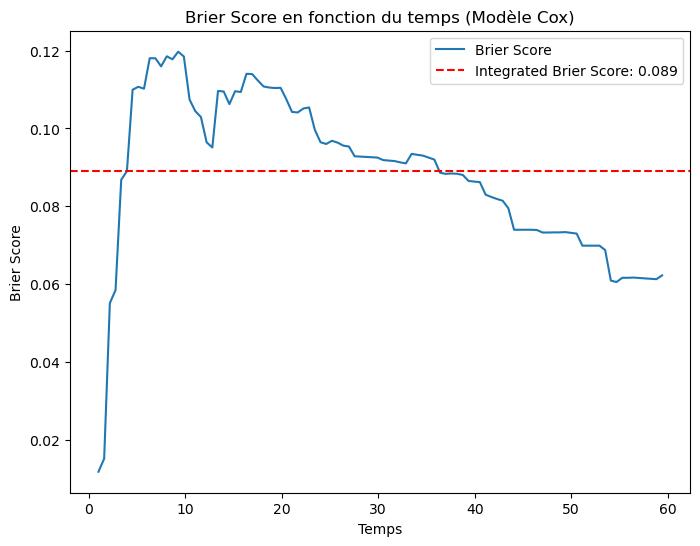

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sksurv.metrics import brier_score, integrated_brier_score

# On suppose que df, time_col, event_col, selected_vars et final_model (CoxPHFitter) sont définis.

# 1. Définir l'intervalle de temps d'évaluation dans [min, max[ 
t_min, t_max = df[time_col].min(), df[time_col].max()
evaluation_times = np.linspace(t_min, t_max, 100, endpoint=False)

# 2. Obtenir la fonction de survie prédite pour chaque individu à partir du modèle Cox
# Ici, surv_df est un DataFrame avec en index les temps et en colonnes les individus
surv_df = final_model.predict_survival_function(df[selected_vars])
n_individuals = surv_df.shape[1]

# Interpoler les courbes de survie sur evaluation_times
surv_preds = np.zeros((n_individuals, len(evaluation_times)))
for i, col in enumerate(surv_df.columns):
    f = interp1d(surv_df.index.values, surv_df[col].values,
                 bounds_error=False,
                 fill_value=(1.0, surv_df[col].values[-1]))
    surv_preds[i, :] = f(evaluation_times)

# 3. Conversion des données de survie en tableau structuré requis par scikit-survival
surv_data = np.array([(bool(e), t) for e, t in zip(df[event_col], df[time_col])],
                     dtype=[('event', bool), ('time', float)])

# 4. Calculer le Brier Score à chaque instant et l'Integrated Brier Score
times, brier_scores = brier_score(surv_data, surv_data, surv_preds, evaluation_times)
ibs = integrated_brier_score(surv_data, surv_data, surv_preds, evaluation_times)
print("Integrated Brier Score: {:.3f}".format(ibs))

# 5. Afficher la courbe du Brier Score et le IBS sur un graphe
plt.figure(figsize=(8, 6))
plt.plot(times, brier_scores, label="Brier Score")
plt.axhline(ibs, color='red', linestyle='--', label=f"Integrated Brier Score: {ibs:.3f}")
plt.xlabel("Temps")
plt.ylabel("Brier Score")
plt.title("Brier Score en fonction du temps (Modèle Cox)")
plt.legend()
plt.show()

## Graphique SHAP

  0%|          | 0/100 [00:00<?, ?it/s]

Importance globale des variables :
               Variable  SHAP_mean_abs  SHAP_mean
2            Metastases       2.113125  -0.001277
6           Adenopathie       1.450924   0.000614
1            Infiltrant       1.168621   0.000274
0                 Tabac       1.127348   0.001962
7              Mucineux       1.125575   0.000265
4           Denitrution       0.958005   0.002605
8       Ulceregastrique       0.834108   0.001834
5          Cardiopathie       0.742378  -0.001567
11  Douleurepigastrique       0.695189  -0.001315
3             Stenosant       0.693302   0.000357
10                  AGE       0.523959  -0.003650
9   Ulcero-bourgeonnant       0.516351  -0.000102


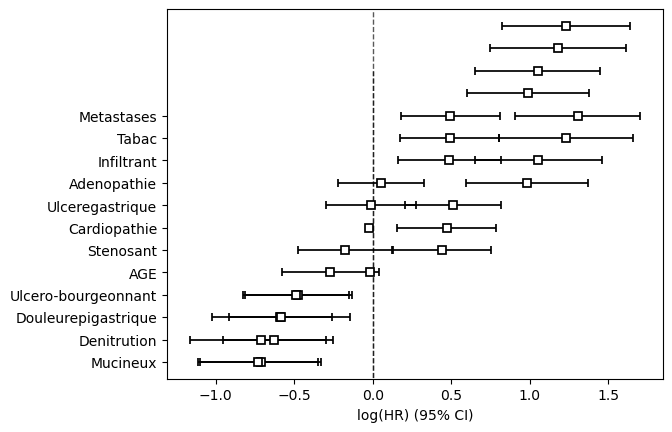

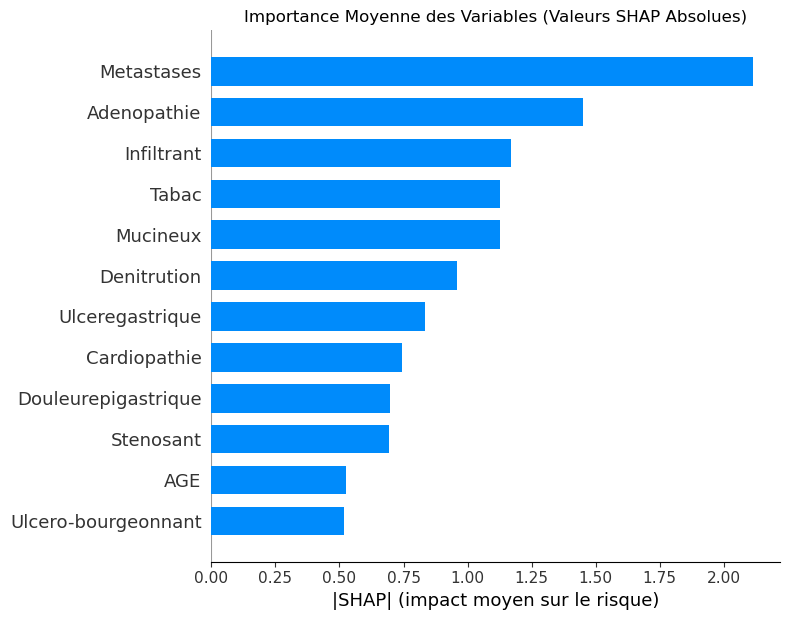

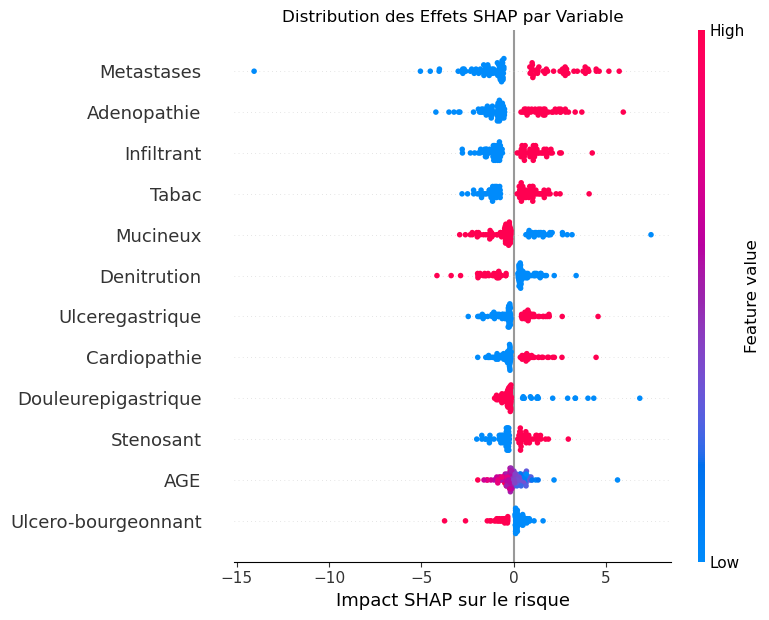

In [27]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

# 1. Calcul des valeurs SHAP --------------------------------------------------
def cox_predict(X):
    return final_model.predict_partial_hazard(X).values

# Échantillonnage pour accélérer le calcul (optionnel)
sample_data = df[selected_vars].sample(n=100, random_state=42)  # 100 observations

explainer = shap.KernelExplainer(cox_predict, sample_data)
shap_values = explainer.shap_values(sample_data)

# 2. DataFrame des SHAP moyens globaux ----------------------------------------
# Calcul de l'importance globale (moyenne des valeurs absolues)
shap_global = pd.DataFrame({
    "Variable": selected_vars,
    "SHAP_mean_abs": np.abs(shap_values).mean(axis=0),
    "SHAP_mean": shap_values.mean(axis=0)
}).sort_values("SHAP_mean_abs", ascending=False)

print("Importance globale des variables :")
print(shap_global[["Variable", "SHAP_mean_abs", "SHAP_mean"]])

# 3. Visualisations globales --------------------------------------------------
plt.figure(figsize=(12, 8))

# A. Graphique d'importance globale
shap.summary_plot(
    shap_values,
    sample_data,
    plot_type="bar",
    show=False
)
plt.title("Importance Moyenne des Variables (Valeurs SHAP Absolues)")
plt.xlabel("|SHAP| (impact moyen sur le risque)")
plt.tight_layout()
plt.savefig("shap_global_importance.png")  # Sauvegarde
plt.show()

# B. Beeswarm plot détaillé
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values,
    sample_data,
    plot_type="dot",
    show=False
)
plt.title("Distribution des Effets SHAP par Variable")
plt.xlabel("Impact SHAP sur le risque")
plt.tight_layout()
plt.savefig("shap_beeswarm.png")
plt.show()

# 4. Export des résultats -----------------------------------------------------
# DataFrame complet des SHAP + données
full_shap_df = pd.DataFrame(shap_values, columns=selected_vars)
full_shap_df = pd.concat([sample_data.reset_index(drop=True), full_shap_df.add_suffix('_SHAP')], axis=1)

In [28]:
print(f"Valeur de base (risque moyen) : {explainer.expected_value:.2f}")

Valeur de base (risque moyen) : 3.57


**Interprétation des résultats** :  
L’analyse SHAP a mis en évidence que **les métastases**, présentes chez 43 % des patients, **ont constitué le facteur de risque principal** avec un impact SHAP de 2,01, indiquant une influence majeure sur l’augmentation du risque. **L’adénopathie** (41 % des cas) et **le tabagisme** (54 % des cas) **ont suivi**, avec des valeurs SHAP respectives de 1,44 et 1,22, confirmant leur rôle significatif dans la prédiction du risque. Les caractéristiques tumorales **infiltrantes** (52 % des cas, SHAP = 1,17) et **mucineux** (65 % des cas, SHAP = 1,11) **ont également contribué de manière notable**, bien qu’avec une intensité légèrement inférieure.  

Parmi les facteurs moins déterminants mais non négligeables, **la dénutrition** (34 % des cas, SHAP = 0,93) et **l’ulcère gastrique** (38 % des cas, SHAP = 0,82) **ont montré un impact modéré**, tandis que **l’âge moyen** (52 ans) **a joué un rôle plus limité** (SHAP = 0,50), malgré sa prévalence systématique. Des variables comme **la douleur épigastrique** (87 % des cas, SHAP = 0,57) et **la forme ulcéro-bourgeonnante** (34 % des cas, SHAP = 0,53) **ont eu une contribution mineure**, reflétant des effets cliniquement moins marqués. Ces résultats **ont souligné l’hétérogénéité des facteurs pronostiques**, avec une prédominance nette des critères tumoraux et comportementaux (tabac) dans l’estimation globale du risque.

In [16]:
# Effacer les variables non pertinantes
clean=['SEXE','Tubuleux','Traitement','Constipation']
df=df.drop(columns=clean,axis=1)

In [18]:
df.columns

Index(['AGE', 'Cardiopathie', 'Ulceregastrique', 'Douleurepigastrique',
       'Ulcero-bourgeonnant', 'Denitrution', 'Tabac', 'Mucineux', 'Infiltrant',
       'Stenosant', 'Metastases', 'Adenopathie', 'Tempsdesuivi (Mois)',
       'Deces'],
      dtype='object')